#Imports

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import collections
import random
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt

#Defines

In [3]:
def import_edge_connections(file_name: str) -> dict:
    """
    Given the name of a file containing information about edges in a graph,
    return a dictionary where the keys are the edge numbers and the values are lists
    containing the numbers of the nodes that the edge connects.
    """
    edge_connections = {}
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge_num = int(parts[0])
            connections = [int(c) for c in parts[1:]]
            edge_connections[edge_num] = connections
    return edge_connections

def import_restrictions(file_name: str) -> List[Tuple[int, int, int]]:
    """
    Given the name of a file containing information about restrictions in a graph,
    return a list of tuples where each tuple contains three integers:
    the numbers of the two edges that are restricted and the distance between them.
    """
    restrictions = []
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge1 = int(parts[0])
            edge2 = int(parts[1])
            prohibited = int(parts[2])
            restrictions.append((edge1, edge2, prohibited))
    return restrictions

In [4]:
def check_condition(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 not in path:
        return False
    elif node3 in path:
        return "Done"
    else:
      return True


In [5]:
def dfs(node: int, visited: List[bool], path: List[int], all_paths: List[List[int]], restrictions_local:  List[List[int]], depth: int):
        visited[node-1] = True
        path.append(node)

        sum_locked = 0
        len_start = len(restrictions_local)
        for restrict in restrictions_local:
          check_result =  check_condition(restrict[0], restrict[1], restrict[2], path)
          if not check_result:
            #print(f" decline {restrict[0], restrict[1], restrict[2], path}")
            sum_locked += 1
          elif check_result == "Done":
           # print(f"Done {restrict[0], restrict[1], restrict[2]}")
            #print(len(restrictions_local))
            restrictions_local.remove(restrict)

        if sum_locked:
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Error"


        if path[-4:-2] == path[-2:]:
          #print(f'declined path {path}')
          path.pop()
          visited[node-1] = False
          return None

        if all(visited):
            #print(visited)
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Done"

        elif depth >= 10 :
            path.pop()
            #print(depth)
            visited[node-1] = False
            return "Max"

        else:
          for neighbor in edge_connections[node]:
                result = dfs(neighbor, visited.copy(), path, all_paths, restrictions_local.copy(),depth+1)

        visited[node-1] = False
        path.pop()


In [6]:
def find_all_paths(edge_connections: dict, restrictions: List[List[int]]) -> List[List[int]]:
    """
    Given a dictionary of edge connections, return a list of all available paths for traversing
    the graph with repetitions, starting and ending at any node, and visiting all nodes.
    """
    all_nodes = list(edge_connections.keys())
    all_paths = []
    for start_node in tqdm(all_nodes):
        #print(f"start {start_node}")
        visited = [False] * len(all_nodes)
        path = []
        dfs(start_node, visited, path, all_paths, restrictions.copy(), 1)

    return all_paths


In [7]:
def clean_list_np(all_path): # Две функции для разных форматов списка
  finall_results = {}
  for path in all_path:
    path = path[0]
    name = ','.join(str(x) for x in np.unique(path))
    #name = str(np.unique(path))
    if name in finall_results.keys() and len(path)>1:
      if len(path) < len(finall_results[name]):
        finall_results[name] = path
    elif  len(path)>1:
      finall_results[name] = path
  return finall_results


In [8]:
def clean_list(all_path, final_name):
  finall_results = {}
  final = []
  for path in all_path:
    name = ','.join(str(x) for x in np.unique(path))
    name = str(np.unique(path))
    # print(len(path))
    if name in finall_results.keys():
      if len(path) < len(finall_results[name]):
        finall_results[name] = path
    elif name == final_name:
      final.append(path)
    else:
      finall_results[name] = path
  print(final)
  if final:
    finall_results[final_name] = final
  return finall_results



In [9]:
def visualize_graph(edge_connections):
    """
    Given a dictionary containing information about the connections between edges in a graph,
    visualize the graph using networkx and matplotlib.
    """
    G = nx.Graph()
    for edge, connections in edge_connections.items():
        for connection in connections:
            G.add_edge(edge, connection)
    pos = nx.spring_layout(G, seed=42) # Layout nodes using the Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)
    plt.show()


In [10]:
def check_condition_order(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return False
      else:
        return True
    else:
      return True


In [11]:
def Extend_Results(results):
  Extended_results = []
  for r1 in results.values():
    for r2 in results.values():
      if r2[0] in edge_connections[r1[-1]] and not np.array_equal(r1,r2): # если r1 является возможным началом r2
        er = 0
        extend_ = []
        extend_.append(np.concatenate((r1,r2)))
        for rest in restrictions:
          if not check_condition_order(rest[0],rest[1],rest[2],extend_[0]):
              er+=1
              break
        if not er:
          Extended_results.append(extend_)
  return(clean_list_np(Extended_results))

In [12]:
def PartWays(path):
  #print(path)
  variations = {}
  for i in range(len(path)-4):
    #print(f"{i} {path[:len(path)-i]}")
    part = ','.join(str(x) for x in np.unique(path[:len(path)-i]))
    variations[part] = path[:len(path)-i]
 # print(variations)S
  return variations



Ниже находится старая функция. Пусть пока побудет тут. Не особо хочу ее удалять

In [13]:
# def recursive_append(paths,visited,doub,result,results,results_list):
#   #print(f"{visited}  {all(visited.values())}")
#   # if results_list:
#   #   actual = str()
#   #   for i in result:
#   #     for k in i.values():
#   #           actual+=str(k)
#   #   for string in results_list:
#   #     if string.find(actual) and (len(actual)/len(string) > 0.9):
#   #       return "Repeat"

#   if all(visited.values()):
#     results.append(result.copy())
#     full_str = str()
#     for string in result:
#       for k in string.values():
#           full_str+=str(k)
#       results_list.append(full_str)
#     #print(f"all {results_list}")
#     return "Done"



#   stop_ = 0
#   steady_state = visited.copy()
#   for path_ in paths:
#     #print(path)
#     paths_ = PartWays(paths[path_])
#     for path in paths_:

#       #print(paths_)
#       for i in path.split(','):
#         if not visited[int(i)] or int(i) in doub:
#           visited[int(i)] +=1
#         else:
#          # print(f"stop {visited[int(i)]} {int(i)}, {doub}")
#           stop_ = 1
#       if stop_:
#         visited = steady_state.copy()
#         stop_ = 0
#         pass
#       else:
#          # print(f"{path} {visited}")
#           result.append({path:paths_[path]})
#           #print(result)
#           recursive_append(paths,visited.copy(),doub,result,results,results_list)
#           result.pop()

In [14]:
def check_condition_order_final(node1, node2, node3, path):
    idx1 = path.index(node1)
    idx2 = path.index(node2)
    idx3 = path.index(node3)
    if idx3 > idx1 and idx3 > idx2:
        return False
    else:
        return True

In [15]:
def recursive_append(paths,visited,doub,result,results,results_list, constraints, depth = 0):

  if all(visited.values()) or (depth > 10):
    _path = []
    for j in result:
      _path.extend(list(j.items())[0][1])
    for cons in constraints:
      if not check_condition_order_final(cons[0],cons[1],cons[2],_path):
        return "Fail"
    results.append(result.copy())
    #print(f"all {results_list}")
    return "Done"



  stop_ = 0
  steady_state = visited.copy()
  for path_ in paths:
    #print(path)
    paths_ = PartWays(paths[path_])
    for path in paths_:

      #print(paths_)
      for i in path.split(','):
        if not visited[int(i)] or int(i) in doub:
          visited[int(i)] +=1
        else:
         # print(f"stop {visited[int(i)]} {int(i)}, {doub}")
          stop_ = 1
      if stop_:
        visited = steady_state.copy()
        stop_ = 0
        pass
      else:
         # print(f"{path} {visited}")
          result.append({path:paths_[path]})
          #print(result)
          recursive_append(paths,visited.copy(),doub,result,results,results_list, constraints, depth + 1)
          result.pop()

In [16]:
def check_shortest_paths(edge_connections, all_path):
  all_shortest_paths = []
  nodes = list(edge_connections.keys())
  for path in all_path:
    name = ','.join(str(x) for x in np.unique(path))
    if all([str(node) in name for node in nodes]) and len(path) == len(nodes):
      all_shortest_paths.append(path)
  return all_shortest_paths

In [17]:
def final_chains_clean_print(final_chains):
  used_ones = []
  num = 0
  for chain in final_chains:
    uniq = 0
    for one in chain:
      try:
        if not one in used_ones:
          uniq+=1
          used_ones.append(one)
      except:
        pass
    if uniq:
      num+=1
      print(f"{num}\t {chain}")
      print('')


#Algorythm


## import tables and visualize

In [18]:
edge_connections = import_edge_connections('./Links Толкатель.txt')
restrictions = import_restrictions('./Constraints Толкатель.txt')


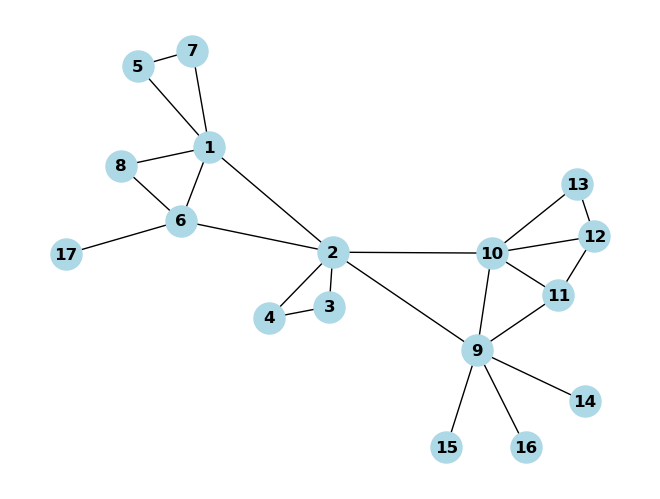

In [19]:
visualize_graph(edge_connections)

## Find all combination without restrictions


In [20]:
all_paths = find_all_paths(edge_connections, restrictions)
final_name = ','.join(str(x) for x in edge_connections)
clean_paths = clean_list(all_paths,final_name)

100%|██████████| 17/17 [00:00<00:00, 378.76it/s]

[]


In [21]:
try:
  clean_paths[final_name]
except:
  pass

In [22]:
all_paths

[[1, 2, 1, 5, 1, 2, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 5, 1, 8],
 [1, 2, 1, 5, 1, 2, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 7, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 7, 1, 8],
 [1, 2, 1, 5, 1, 2, 1, 8],
 [1, 2, 1, 5, 1, 2, 3],
 [1, 2, 1, 5, 1, 2, 4],
 [1, 2, 1, 5, 1, 2, 6],
 [1, 2, 1, 5, 1, 2, 9],
 [1, 2, 1, 5, 1, 2, 10],
 [1, 2, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 1, 8],
 [1, 2, 1, 5, 1, 7, 1, 2, 3],
 [1, 2, 1, 5, 1, 7, 1, 2, 4],
 [1, 2, 1, 5, 1, 7, 1, 2, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 9],
 [1, 2, 1, 5, 1, 7, 1, 2, 10],
 [1, 2, 1, 5, 1, 7, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 5, 1, 8],
 [1, 2, 1, 5, 1, 7, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 8],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 3],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 4],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 6],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 9],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 10],
 [1, 2, 1, 5, 1, 7, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 5, 1, 8],
 [1, 2, 1, 5, 1, 7, 5, 7, 1, 6],
 [1, 2, 1, 5, 1, 7, 5, 7, 1, 8],
 [1, 2, 1, 5, 1, 8],
 [1, 2, 1, 5, 7, 1, 2,

In [23]:
check_shortest_paths(edge_connections, all_paths)

[]

##Extend clean list combinations with its own combinations without errors(construct step)

In [24]:
clean_paths

{'[1 2 5 6]': [2, 1, 5, 1, 6],
 '[1 2 5 8]': [2, 1, 5, 1, 8],
 '[1 2 5 6 7]': [2, 1, 5, 7, 1, 6],
 '[1 2 5 7 8]': [2, 1, 5, 7, 1, 8],
 '[1 2 3 5]': [2, 1, 5, 1, 2, 3],
 '[1 2 4 5]': [2, 1, 5, 1, 2, 4],
 '[1 2 5 9]': [2, 1, 5, 1, 2, 9],
 '[ 1  2  5 10]': [2, 1, 5, 1, 2, 10],
 '[1 2 3 5 7]': [2, 1, 5, 7, 1, 2, 3],
 '[1 2 4 5 7]': [2, 1, 5, 7, 1, 2, 4],
 '[1 2 5 7 9]': [2, 1, 5, 7, 1, 2, 9],
 '[ 1  2  5  7 10]': [2, 1, 5, 7, 1, 2, 10],
 '[1 2 6]': [1, 2, 6],
 '[1 2 6 7]': [7, 1, 2, 6],
 '[1 2 7 8]': [2, 1, 7, 1, 8],
 '[1 2 3 7]': [7, 1, 2, 3],
 '[1 2 4 7]': [7, 1, 2, 4],
 '[1 2 7 9]': [7, 1, 2, 9],
 '[ 1  2  7 10]': [7, 1, 2, 10],
 '[1 2 8]': [2, 1, 8],
 '[1 2 3]': [1, 2, 3],
 '[1 2 4]': [1, 2, 4],
 '[1 2 9]': [1, 2, 9],
 '[ 1  2 10]': [1, 2, 10],
 '[1 5]': [1, 5],
 '[1 5 6]': [6, 1, 5],
 '[1 5 6 7]': [6, 1, 7, 5],
 '[1 6 7 8]': [7, 1, 6, 8],
 '[ 1  2  6  7 17]': [7, 1, 6, 17, 6, 2],
 '[ 1  5  6  7 17]': [17, 6, 1, 7, 5],
 '[1 6 8]': [1, 6, 8],
 '[ 1  2  6 17]': [17, 6, 1, 2],
 '[ 1  5  6

In [25]:
import pandas as pd
df = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["start","end","body","connections"] )
df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})

for i,r1 in enumerate(clean_paths.values()):
    df.at[i,"start"] = r1[0]
    df.at[i,"end"] = r1[-1]
    df.at[i,"body"] = r1
    df.at[i,"connections"] = []
    df.at[i,"unique"] = len(pd.unique(r1))

for node in edge_connections:
    started = df[df["start"] == node].index
    _ = df[df["end"].isin(edge_connections[node])]["connections"].apply(lambda x: x.extend(started))

df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object, "unique" :int})


In [26]:
def greedy_cover(stations: dict, depth: int):
    """
    Используйте жадный алгоритм для решения установленной проблемы покрытия: выберите наименее вещательную станцию, чтобы все области могли принимать сигнал
    :param stations:
    :return:
    """

    # Создайте набор для хранения областей, которые должны быть покрыты, но еще не покрыты
    not_cover = set()
    for v in stations.values():
        for s in v:
            not_cover.add(s)
    selects = []  # Сохранить нашу выбранную станцию
    alternatives = [] # set list of alternative step starts
    current_depth = 0
    while True:
        # Сначала выберите станцию, которая покрывает наиболее непокрытую территорию
        max_key = ''
        max_num = 0
        for k in stations.keys(): # can be sorted, so it will be faster)
            intersection = not_cover.intersection(stations[k])
            if len(intersection) > max_num:
                max_key = k
                max_num = len(intersection)
                alternatives = [k,]
            elif len(intersection) == max_num and current_depth == depth:
                alternatives.append(k)

        if current_depth == depth:
            #print(alternatives, current_depth, selects)
            break  

        selects.append(max_key)
        # Затем удалите зону покрытия выбранной радиостанции из not_cover
        for e in stations[max_key]:
            if e in not_cover:
                not_cover.remove(e)
        
        current_depth += 1

    solutions = [selects+[alt] for alt in alternatives]
    not_cover_steady_state = not_cover.copy()
    #print(solutions)

    for i, alt in enumerate(alternatives):
        not_cover = not_cover_steady_state.copy()
        for e in stations[alt]:
            if e in not_cover:
                not_cover.remove(e)
        
        while True:
            # Сначала выберите станцию, которая покрывает наиболее непокрытую территорию
            max_key = ''
            max_num = 0
            for k in stations.keys():
                intersection = not_cover.intersection(stations[k])
                if len(intersection) > max_num:
                    max_key = k
                    max_num = len(intersection)
            solutions[i].append(max_key)
            # Затем удалите зону покрытия выбранной радиостанции из not_cover
            for e in stations[max_key]:
                if e in not_cover:
                    not_cover.remove(e)
            # Если not_cover не пусто, то есть покрыты все области, можно завершить алгоритм
            if (len(not_cover) == 0 ):
                break

    return solutions

In [27]:
%%time
print(greedy_cover(df.to_dict("dict")["body"], depth = 0))

[[77, 126, 28, 99]]
CPU times: total: 15.6 ms
Wall time: 2 ms


Check restrections

In [28]:
import itertools as it
from collections import Counter
results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
uniques = len(edge_connections)
operations_count = len(results[0])
body_part = 2
id_checked = []

solutions = pd.DataFrame(np.zeros((1,2)), 
                      columns= ["operations","order"] )
solutions = solutions.astype({ "operations" : object,"order" : object})
df_rows_counter = 0

for iter_i in tqdm(range(1000)):
    results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
    for res in results:
        for var in it.permutations(res):
            if not any([np.array_equal(var,i) for i in id_checked]):
                id_checked.append(var)
                #print(f"finded {var} in {res}")
            else:
                #print(f"skipped {var} in {res}")
                continue
            result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
            for_output = df.iloc[list(var)]["body"].values
            for i in it.combinations(result_path,uniques + operations_count - 1):
                if (len(set(i)) == uniques) and Counter(i)[body_part]==operations_count:
                    if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {i}")
                        # solutions.at[df_rows_counter,"operations"] = [list(pd.unique(one)) for one in for_output]
                        # solutions.at[df_rows_counter,"order"] = i
                        solutions.loc[len(solutions.index)+1] = [[list(pd.unique(one)) for one in for_output], i]

  0%|          | 0/1000 [00:17<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "c:\ProgramData\mambaforge\envs\GAN\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Temp\ipykernel_1516\699213536.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\mambaforge\envs\GAN\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\mambaforge\envs\GAN\Lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\mambaforge\envs\GAN\Lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback

In [88]:
counts = []
for i in tqdm(range(1000)):
    counts.append(len(greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 1)[0]))
l0 = pd.value_counts(counts).index[0]
l1 = pd.value_counts(counts).index[1]
id_checked0 = np.zeros((1,l0))
id_checked1 = np.zeros((1,l1))

100%|██████████| 1000/1000 [00:00<00:00, 1267.60it/s]


In [89]:
import time
import itertools as it
from collections import Counter
results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
uniques = len(edge_connections)
body_part = 2
start = time.time()
one_time = 5*60/1000 # лучше меньше итераций
solutions = pd.DataFrame(np.zeros((1,2)), 
                      columns= ["operations","order"] )
solutions = solutions.astype({ "operations" : object,"order" : object})
df_rows_counter = 0

for iter_i in tqdm(range(1000)):
    results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
    isl0 = (len(results[0]) == l0) # check length of path
    isl1 = (len(results[0]) == l1) # check length of path
    for res in results:
        
        for var in it.permutations(res):
            if isl0:
                if not any([np.array_equal(var,i) for i in id_checked0]):
                    operations_count = l0
                    id_checked0 = np.concatenate((id_checked0,[var]))
                    #print(f"finded {var} in {res}")
                else:
                    continue
            elif isl1:
                if not any([np.array_equal(var,i) for i in id_checked1]):
                    operations_count = l1
                    id_checked1 = np.concatenate((id_checked1,[var]))
                    #print(f"finded {var} in {res}")
                else:
                    continue
            else:
                break

            result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
            for_output = df.iloc[list(var)]["body"].values

            for i in it.combinations(result_path,uniques + operations_count - 1):
                if (len(set(i)) == uniques) and Counter(i)[body_part]==operations_count:
                    if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {i}")
                        # solutions.at[df_rows_counter,"operations"] = [list(pd.unique(one)) for one in for_output]
                        # solutions.at[df_rows_counter,"order"] = i
                        solutions.loc[len(solutions.index)+1] = [[list(pd.unique(one)) for one in for_output], i]
                if (time.time() - start) > one_time * (iter_i+1):
                    #print(f"passed {iter_i} couss {time.time()} - {start* (iter_i+1)} > {one_time}({time.time() - start* (iter_i+1)})")
                    break

 32%|███▏      | 323/1000 [01:31<01:09,  9.70it/s]

Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [3, 2, 6, 17, 8, 9], [9, 11, 12, 13]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 12, 10, 2, 17, 8, 2, 13)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [3, 2, 6, 17, 8, 9], [9, 11, 12, 13]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 10, 2, 17, 8, 2, 12, 13)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [3, 2, 6, 17, 8, 9], [9, 11, 12, 13]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 12, 10, 2, 17, 8, 2, 11, 13)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [3, 2, 6, 17, 8, 9], [9, 11, 12, 13]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 10, 2, 17, 8, 2, 11, 12, 13)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [3, 2, 6, 17, 8, 9], [9, 11, 12, 13]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 15, 9, 16, 11, 12, 1

 63%|██████▎   | 628/1000 [03:08<01:39,  3.74it/s]

Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [10, 13], [3, 2, 6, 17, 8, 10]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 12, 10, 13, 2, 17, 8, 2)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [10, 13], [3, 2, 6, 17, 8, 10]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 12, 10, 13, 2, 17, 8, 2)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [10, 13], [3, 2, 6, 17, 8, 10]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 15, 9, 16, 11, 12, 10, 13, 2, 17, 8, 2)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [10, 13], [3, 2, 6, 17, 8, 10]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 15, 9, 16, 11, 12, 10, 13, 2, 17, 8, 2)
Решение найдено. Из обхода [[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11, 12, 10], [10, 13], [3, 2, 6, 17, 8, 10]] подходит путь (2, 3, 4, 2, 1, 5, 7, 6, 14, 15, 16, 9, 11, 12, 10, 13, 2, 17, 8, 2)
Решение на

100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


In [43]:
time.time() - start

61.06651449203491

In [44]:
one_time

30.0

In [87]:
len(solutions)

16

In [72]:
len(solutions)

97

In [73]:
solutions

,operations,order
0,0.0,0.0
2,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 12..."
3,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 12..."
4,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 10..."
5,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 1, 5, 7, 6, 14, 9, 15, 16, 11, 2,..."
...,...,...
93,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 5, 7, 1, 6, 14, 15, 16, 9, 11, 2,..."
94,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 5, 7, 1, 6, 14, 15, 16, 9, 12, 10..."
95,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 5, 7, 1, 6, 14, 15, 16, 9, 12, 2,..."
96,"[[2, 3, 4, 1, 5, 7, 6, 8], [14, 9, 15, 16, 11,...","(2, 3, 4, 2, 5, 7, 1, 6, 14, 15, 16, 9, 10, 2,..."


In [ ]:
any([np.array_equal(var,i) for i in solutions["order"]])

False

In [ ]:
for i in it.combinations([6,7,1,7,8,7,1,2,4,2,1,3,9,10,1,5],10):
        if len(set(i)) == len(set(result_path)):
            if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                print(i)

(6, 7, 7, 8, 2, 4, 3, 9, 10, 5)
(6, 7, 7, 8, 4, 2, 3, 9, 10, 5)
(6, 7, 8, 7, 2, 4, 3, 9, 10, 5)
(6, 7, 8, 7, 4, 2, 3, 9, 10, 5)
(6, 7, 8, 2, 4, 2, 3, 9, 10, 5)
(6, 7, 8, 7, 2, 4, 3, 9, 10, 5)
(6, 7, 8, 7, 4, 2, 3, 9, 10, 5)
(6, 7, 8, 2, 4, 2, 3, 9, 10, 5)
(6, 8, 7, 2, 4, 2, 3, 9, 10, 5)


In [ ]:
for i in it.combinations([1,2,3,4,5,6,7,8,9,10,1],10):
        print(i)
        if len(set(i)) == len(set(result_path)):
            if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                print(i)

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
(1, 2, 3, 4, 5, 6, 7, 8, 9, 1)
(1, 2, 3, 4, 5, 6, 7, 8, 10, 1)
(1, 2, 3, 4, 5, 6, 7, 9, 10, 1)
(1, 2, 3, 4, 5, 6, 8, 9, 10, 1)
(1, 2, 3, 4, 5, 7, 8, 9, 10, 1)
(1, 2, 3, 4, 6, 7, 8, 9, 10, 1)
(1, 2, 3, 5, 6, 7, 8, 9, 10, 1)
(1, 2, 4, 5, 6, 7, 8, 9, 10, 1)
(1, 2, 4, 5, 6, 7, 8, 9, 10, 1)
(1, 3, 4, 5, 6, 7, 8, 9, 10, 1)
(1, 3, 4, 5, 6, 7, 8, 9, 10, 1)
(2, 3, 4, 5, 6, 7, 8, 9, 10, 1)


In [ ]:
np.is i(counts>1)

SyntaxError: invalid syntax (1202574606.py, line 1)

In [ ]:
len(set(result_path))

10

In [ ]:
result_path

array([ 6,  7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  3,  4,  2,  1,  5])

In [ ]:
np.concatenate([result_path,result_path])

array([ 6,  7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  3,  4,  2,  1,  5,  6,
        7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  3,  4,  2,  1,  5])

In [ ]:
for i in it.combinations(result_path,10):
   if len(set(i)) == len(set(result_path)):
     print(i)
     if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
        print(i)

(6, 7, 1, 8, 2, 9, 10, 3, 4, 5)
(6, 7, 1, 8, 9, 10, 3, 4, 2, 5)
(6, 7, 8, 1, 2, 9, 10, 3, 4, 5)
(6, 7, 8, 1, 9, 10, 3, 4, 2, 5)
(6, 7, 8, 2, 9, 10, 1, 3, 4, 5)
(6, 7, 8, 2, 9, 10, 3, 4, 1, 5)
(6, 7, 8, 9, 10, 1, 3, 4, 2, 5)
(6, 7, 8, 9, 10, 3, 4, 2, 1, 5)
(6, 1, 7, 8, 2, 9, 10, 3, 4, 5)
(6, 1, 7, 8, 9, 10, 3, 4, 2, 5)
(6, 1, 8, 7, 2, 9, 10, 3, 4, 5)
(6, 1, 8, 7, 9, 10, 3, 4, 2, 5)
(6, 7, 8, 1, 2, 9, 10, 3, 4, 5)
(6, 7, 8, 1, 9, 10, 3, 4, 2, 5)
(6, 7, 8, 2, 9, 10, 1, 3, 4, 5)
(6, 7, 8, 2, 9, 10, 3, 4, 1, 5)
(6, 7, 8, 9, 10, 1, 3, 4, 2, 5)
(6, 7, 8, 9, 10, 3, 4, 2, 1, 5)
(6, 8, 7, 1, 2, 9, 10, 3, 4, 5)
(6, 8, 7, 1, 9, 10, 3, 4, 2, 5)
(6, 8, 7, 2, 9, 10, 1, 3, 4, 5)
(6, 8, 7, 2, 9, 10, 3, 4, 1, 5)
(6, 8, 7, 9, 10, 1, 3, 4, 2, 5)
(6, 8, 7, 9, 10, 3, 4, 2, 1, 5)


In [ ]:
set()

In [ ]:
result_path

array([ 6,  7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  3,  4,  2,  1,  5])

In [ ]:
np.sort([2,1])

array([1, 2])

In [ ]:
result_path[np.sort([2,1,5,3,4])]

array([7, 1, 7, 8, 7])

In [ ]:
np.where(np.isin(result_path,[1,2]))

(array([ 2,  6,  7, 10, 13, 14], dtype=int64),)

In [ ]:
for i in it.combinations([np.random.randint(0,10) for i in range(30)],10):
    if len(np.unique(i)) == 10:
        print(i)

KeyboardInterrupt: 

In [ ]:
import itertools as it
for i in it.combinations(result_path,10):
    print(i)


(6, 7, 1, 7, 8, 7, 1, 2, 9, 10)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 3)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 4)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 2)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 9, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 3)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 4)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 2)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 10, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 3)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 4)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 2)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 3, 4)
(6, 7, 1, 7, 8, 7, 1, 2, 3, 2)
(6, 7, 1, 7, 8, 7, 1, 2, 3, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 3, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 4, 2)
(6, 7, 1, 7, 8, 7, 1, 2, 4, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 4, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 2, 1)
(6, 7, 1, 7, 8, 7, 1, 2, 2, 5)
(6, 7, 1, 7, 8, 7, 1, 2, 1, 5)
(6, 7, 1, 7, 8, 7, 1, 9, 10, 1)
(6, 7, 1, 7, 8, 7, 1, 9, 10, 3)
(6, 7, 1, 7, 8, 7, 1, 9, 10, 4)
(6, 7, 1, 7, 8, 7, 1, 9, 10, 

In [ ]:
df.iloc[greedy_cover(a,1)[0]]

IndexError: positional indexers are out-of-bounds

In [ ]:
df.iloc[greedy_cover(a,1)[1]]

[126, 127] 1 [77]
[[77, 126], [77, 127]]


,start,end,body,connections,unique
77,2,8,"[2, 3, 4, 1, 5, 7, 6, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",8
127,14,13,"[14, 9, 15, 16, 11, 12, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",7
61,2,10,"[2, 3, 4, 6, 17, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",6


# 6 7 1 8 2 9 10 3 4  5

In [ ]:
res = np.unique(path,return_counts=True)

In [ ]:
res

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], dtype=int64))

In [ ]:
res

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1], dtype=int64))

In [ ]:
[check_condition_order(rest[0],rest[1],rest[2],res) for rest in restrictions]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
path = np.concatenate(list(df.iloc[greedy_cover(a,1)]["body"]))
while not (all([check_condition_order(rest[0],rest[1],rest[2],path) for rest in restrictions])) and len(np.unique(path))==10):
    res = np.unique(path,return_counts=True)
    for val,count in zip(res[0],res[1]):
        if count > 1:
            for i in np.where(path==val):
                if not all([check_condition_order(rest[0],rest[1],rest[2],path) for rest in restrictions]):
                    print(path)
                    path = np.delete(path,i)
        

SyntaxError: unmatched ')' (3322893848.py, line 2)

In [ ]:
path

array([ 6,  7,  8,  2,  9, 10,  3,  4,  2,  5])

In [ ]:
res==val

array([[ True, False, False, False, False, False, False, False, False,
        False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [ ]:
pd.concat(df.iloc[greedy_cover(a,1)]["body"])

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "Series"

In [ ]:
df.iloc[greedy_cover(a,1)]["body"].flatten()

AttributeError: 'Series' object has no attribute 'flatten'

In [ ]:
df.body[9]

[4, 2, 1, 10]

In [ ]:
df.to_csv("./test.csv",sep = ";", columns=["start","end","body", "unique"])

In [ ]:
def extending_df(df_row):
    ext_paths = []
    for con in df_row["connections"]:
        ext_path = np.append(df_row["body"],df.at[con,"body"])
        while not all([check_condition_order(rest[0],rest[1],rest[2],ext_path) for rest in restrictions]):
            ext_path = ext_path[:-1]

        if np.array_equal(ext_path, df_row["body"]):
            continue
        else:
            ext_paths.append(ext_path)
    return ext_paths

In [ ]:
res = df.progress_apply(extending_df,axis = 1)

100%|██████████| 1838/1838 [08:45<00:00,  3.49it/s]


In [ ]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [ ]:
final = []
for r in res:
    final.extend(r)
print(len(final))

826609


In [ ]:
ext_df = pd.DataFrame(np.zeros((len(final),4)), 
                      columns= ["start","end","body","connections"] )
ext_df = ext_df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})


In [ ]:
for i,r1 in enumerate(final):
    body = pd.unique(r1)
    ext_df.at[i,"body"] = body
    ext_df.at[i,"connections"] = []
    ext_df.at[i,"start"] = body[0]
    ext_df.at[i,"end"] = body[-1]

ext_df = ext_df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})

In [ ]:
df = pd.concat((df,ext_df), ignore_index=True)

In [ ]:
df = df[~df['body'].apply(tuple).duplicated()].reset_index(drop=True)

In [ ]:
df

,start,end,body,connections
0,2,6,"[2, 1, 5, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ..."
1,2,8,"[2, 1, 5, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 8..."
2,2,6,"[2, 1, 5, 7, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ..."
3,2,8,"[2, 1, 5, 7, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 8..."
4,2,3,"[2, 1, 5, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,..."
...,...,...,...,...
55071,12,15,"[12, 13, 11, 9, 16, 15]",[]
55072,12,2,"[12, 13, 11, 9, 16, 2]",[]
55073,12,16,"[12, 13, 11, 9, 14, 15, 2, 3, 16]",[]
55074,12,15,"[12, 13, 11, 9, 14, 16, 2, 3, 15]",[]


In [ ]:
for node in edge_connections:
    started = df[df["start"] == node].index
    _ = df[df["end"].isin(edge_connections[node])]["connections"].apply(lambda x: x.extend(started))

KeyboardInterrupt: 

_____

In [ ]:
ext_path = np.append(df.at[17,"body"],df.at[45,"body"])

In [ ]:
df.at[17,"body"]

array([6, 7, 1, 8, 2])

In [ ]:
df.at[45,"body"]

array([4, 2, 1, 3, 5])

In [ ]:
df.at[17,"body"] == df.at[45,"body"]

array([False, False,  True, False, False])

In [ ]:
ext_path.drop_duplicates()

AttributeError: 'numpy.ndarray' object has no attribute 'drop_duplicates'

In [ ]:
pd.unique(ext_path)

array([6, 7, 1, 8, 2, 4, 3, 5])

In [ ]:
ext_path

array([6, 7, 1, 8, 2, 4, 2, 1, 3, 5])

In [ ]:
e = np.array((6,7,8,4,2,1,3,5))

In [ ]:
[check_condition_order(rest[0],rest[1],rest[2],e) for rest in restrictions]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
df.at[17,"body"]

array([6, 7, 1, 8, 2])

In [ ]:
for b in df["body"]

0                   [1, 2]
1                   [1, 3]
2                   [1, 5]
3                   [1, 7]
4                  [1, 10]
              ...         
231    [1, 2, 10, 7, 3, 5]
232    [1, 7, 2, 3, 5, 10]
233    [1, 7, 2, 3, 10, 5]
234    [1, 7, 2, 10, 3, 5]
235    [1, 10, 2, 7, 3, 5]
Name: body, Length: 236, dtype: object

In [ ]:
df.iloc[158]["body"] == df.iloc[159]["body"]

array([ True,  True,  True,  True])

In [ ]:
df["body"].value_counts()

body
[1, 2]              1
[1, 3]              1
[6, 7, 1, 3]        1
[6, 7, 1, 3, 10]    1
[6, 7, 1, 5, 2]     1
                   ..
[2, 3]              1
[2, 3]              1
[4, 2, 1, 3]        1
[4, 2, 1, 3]        1
[9, 10, 1, 7]       1
Name: count, Length: 160, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
global gap
gap = 0
ext_df = pd.DataFrame(np.zeros((sum(df["connections"].apply(len)),4)), 
                      columns= ["start","end","body","connections"] )
ext_df = ext_df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})

def extending_df(df_row):
    global gap
    skipped = 0
    for con in df_row["connections"]:
        new_body = np.array(df_row["body"] + df.at[con,"body"])
        if len(new_body)>20:
            skipped+=1
        skipped += df_row["body"] == df.at[con,"body"]
        for rest in restrictions:
            if not check_condition_order(rest[0],rest[1],rest[2],new_body):
                skipped+=1
                break
        if skipped:
            #ext_df.drop(index = ext_df.shape[0]-1, inplace=True)
            continue
        ext_df.at[gap, "body"] = new_body
        gap+=1
    return skipped
        #ext_df.at[i, "start"] = df_row["start"]


np.sum(df.progress_apply(extending_df, axis=1))

100%|██████████| 27/27 [00:00<00:00, 1177.12it/s]


148

In [ ]:
df.drop_duplicates(subset=["start"],inplace=True)

In [ ]:
ext_df

,start,end,body,connections
0,0,0,"[1, 5, 1, 2]",0.0
1,0,0,"[1, 7, 1, 2]",0.0
2,0,0,"[1, 7, 1, 3]",0.0
3,0,0,"[1, 7, 1, 5]",0.0
4,0,0,"[1, 10, 1, 2]",0.0
...,...,...,...,...
242,0,0,0.0,0.0
243,0,0,0.0,0.0
244,0,0,0.0,0.0
245,0,0,0.0,0.0


In [ ]:
df

,start,end,body,connections
0,1.0,2.0,"[1, 2]","[0, 1, 2, 3, 4, 11, 12, 6, 7, 8, 9]"
1,1.0,3.0,"[1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]"
2,1.0,5.0,"[1, 5]","[0, 1, 2, 3, 4, 11, 12]"
3,1.0,7.0,"[1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20..."
4,1.0,10.0,"[1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]"
5,2.0,3.0,"[2, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]"
6,4.0,3.0,"[4, 2, 1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]"
7,4.0,5.0,"[4, 2, 1, 5]","[0, 1, 2, 3, 4, 11, 12]"
8,4.0,7.0,"[4, 2, 1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20..."
9,4.0,10.0,"[4, 2, 1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]"


In [ ]:
while gap!=0:
    print("new\n")
    gap = 0
    def t(raw_df):
        if np.all(raw_df["body"] == 0.0):
            ext_df.drop(index=raw_df.name,inplace=True)
            return 0 
        ext_df.at[raw_df.name,"start"] = raw_df["body"][0]
        ext_df.at[raw_df.name,"end"] = raw_df["body"][-1]
        ext_df.at[raw_df.name,"connections"] = []
    
    ext_df.progress_apply(t,axis = 1)
    print("apply1\n")
    df = ext_df.copy(deep =True)

    for node in tqdm(edge_connections):
            started = df[df["start"] == node].index
            _ = df[df["end"].isin(edge_connections[node])]["connections"].apply(lambda x: x.extend(started))
    ext_df = pd.DataFrame(np.zeros((sum(df["connections"].apply(len)),4)), 
                        columns= ["start","end","body","connections"] )
    ext_df = ext_df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})
    
    def extending_df(df_row):
        global gap
        for con in df_row["connections"]:
            new_body = np.concatenate((df_row["body"],df.at[con,"body"]))
            skipped = np.array_equal(df_row["body"],df.at[con,"body"])
            if len(new_body)>9:
                skipped+=1
            for rest in restrictions:
                if not check_condition_order(rest[0],rest[1],rest[2],new_body):
                    skipped+=1
                    break
            if skipped:
                continue
            
            ext_df.at[gap, "body"] = pd.unique(new_body)
            gap+=1
            #ext_df.at[i, "start"] = df_row["start"]
    
    print(ext_df.shape)
    _ = df.progress_apply(extending_df, axis=1)
    print(gap)



new

apply1



100%|██████████| 10/10 [00:00<00:00, 1670.31it/s]


(1113, 4)


100%|██████████| 56/56 [00:00<00:00, 550.52it/s]

41
new



apply1



100%|██████████| 10/10 [00:00<00:00, 1669.84it/s]


(1681, 4)


100%|██████████| 41/41 [00:00<00:00, 192.10it/s]


1061
new

apply1



100%|██████████| 10/10 [00:00<00:00, 159.23it/s]


(1125721, 4)


100%|██████████| 1061/1061 [01:56<00:00,  9.08it/s]


163056
new



KeyboardInterrupt: 

In [ ]:
df

,start,end,body,connections
0,1,2,"[1, 5, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,2,"[1, 7, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1,3,"[1, 7, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1,5,"[1, 7, 1, 5]","[0, 1, 2, 3, 4, 5, 6, 7]"
4,1,2,"[1, 10, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,1,3,"[1, 10, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,1,5,"[1, 10, 1, 5]","[0, 1, 2, 3, 4, 5, 6, 7]"
7,1,7,"[1, 10, 1, 7]","[0, 1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26, 2..."
8,4,2,"[4, 2, 1, 3, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
9,4,3,"[4, 2, 1, 3, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
pd.unique(df["body"][0])

array([1, 5, 2])

In [ ]:
df["body"][0]

array([1, 5, 1, 2])

In [ ]:
df

,start,end,body,connections
0,1,2,"[1, 5, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,2,"[1, 7, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1,3,"[1, 7, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1,5,"[1, 7, 1, 5]","[0, 1, 2, 3, 4, 5, 6, 7]"
4,1,2,"[1, 10, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,1,3,"[1, 10, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,1,5,"[1, 10, 1, 5]","[0, 1, 2, 3, 4, 5, 6, 7]"
7,1,7,"[1, 10, 1, 7]","[0, 1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26, 2..."
8,4,2,"[4, 2, 1, 3, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
9,4,3,"[4, 2, 1, 3, 1, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
9 10 1 7 5 2

In [ ]:
def Extend_Results(results):
  Extended_results = []
  for r1 in results.values():
    for r2 in results.values():
      if r2[0] in edge_connections[r1[-1]] and not np.array_equal(r1,r2): # если r1 является возможным началом r2
        er = 0
        extend_ = []
        extend_.append(np.concatenate((r1,r2)))
        for rest in restrictions:
          if not check_condition_order(rest[0],rest[1],rest[2],extend_[0]):
              er+=1
              break
        if not er:
          Extended_results.append(extend_)
  return(clean_list_np(Extended_results))

In [ ]:
ext = Extend_Results(clean_paths)
results = clean_paths.copy()
while True:
  if ext:
    print(len(results))
    results = ext | results
    ext = Extend_Results(ext)
  else:
    break


27
84
116
116
116


In [ ]:
np.array([ 4,  2,  1,  7,  1,  3,  1,  5,  1, 10])

array([ 4,  2,  1,  7,  1,  3,  1,  5,  1, 10])

In [ ]:
results

{'1,2,3,4,5,7,10': array([ 4,  2,  1,  7,  1,  3,  1,  5,  1, 10]),
 '1,2,3,5,6,7,10': array([ 6,  7,  1,  2,  1,  3,  1,  5,  1, 10]),
 '1,2,5,6,7,8,10': array([ 6,  7,  1,  7,  8,  7,  1,  2,  1,  2,  1,  5,  1, 10]),
 '1,2,3,5,6,7,8,10': array([ 6,  7,  1,  7,  8,  7,  1,  2,  1,  3,  1,  5,  1, 10]),
 '1,2,3,5,7,9,10': array([ 9, 10,  1,  2,  1,  7,  1,  2,  3,  5]),
 '1,2,3,5,7,10': array([ 1,  7,  1, 10,  1,  2,  3,  5]),
 '1,2,3,4,5,10': array([ 4,  2,  1,  3,  1,  2,  1,  5,  1, 10]),
 '1,2,4,5,7,10': array([ 4,  2,  1,  5,  1,  2,  1,  7,  1, 10]),
 '1,2,3,4,5,7': array([4, 2, 1, 7, 1, 2, 1, 2, 3, 5]),
 '1,2,3,4,7,10': array([ 4,  2,  1,  7,  1,  2,  1,  3,  1, 10]),
 '1,2,3,5,6,7': array([6, 7, 1, 2, 3, 5]),
 '1,2,3,6,7,10': array([ 6,  7,  1,  2,  1,  2,  1,  3,  1, 10]),
 '1,2,5,6,7,10': array([ 6,  7,  1,  2,  1,  2,  1,  5,  1, 10]),
 '1,2,5,6,7,8': array([6, 7, 1, 7, 8, 7, 1, 2, 1, 5]),
 '1,2,3,6,7,8,10': array([ 6,  7,  1,  7,  8,  7,  1,  2,  1,  2,  1,  3,  1, 10]),
 

In [ ]:
len(results)

116

In [ ]:
inPath = { key:0 for key in list(edge_connections.keys())}
final_dict = results
doub = [1,]
result = []
final_chains = []
results_list = []
recursive_append(final_dict,inPath,doub,result,final_chains,results_list,restrictions)
final_chains_clean_print(final_chains)

visualize_graph(edge_connections)

ValueError: 2 is not in list

посмотреть повторы в конце путей + изменить логику игнорирования повторных элементов(Разный порядок сборки эл-ов)

Граф рекомендаций(к примеру после 3 стоит 5 )

## Всякие принты


In [ ]:
print("Все возможные комбинации без нарушений \n")
all_paths

Все возможные комбинации без нарушений 



[[1, 2, 1, 5, 1, 2, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 5, 1, 8],
 [1, 2, 1, 5, 1, 2, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 7, 1, 6],
 [1, 2, 1, 5, 1, 2, 1, 7, 1, 8],
 [1, 2, 1, 5, 1, 2, 1, 8],
 [1, 2, 1, 5, 1, 2, 3],
 [1, 2, 1, 5, 1, 2, 4],
 [1, 2, 1, 5, 1, 2, 6],
 [1, 2, 1, 5, 1, 2, 9],
 [1, 2, 1, 5, 1, 2, 10],
 [1, 2, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 1, 8],
 [1, 2, 1, 5, 1, 7, 1, 2, 3],
 [1, 2, 1, 5, 1, 7, 1, 2, 4],
 [1, 2, 1, 5, 1, 7, 1, 2, 6],
 [1, 2, 1, 5, 1, 7, 1, 2, 9],
 [1, 2, 1, 5, 1, 7, 1, 2, 10],
 [1, 2, 1, 5, 1, 7, 1, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 5, 1, 8],
 [1, 2, 1, 5, 1, 7, 1, 6],
 [1, 2, 1, 5, 1, 7, 1, 8],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 3],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 4],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 6],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 9],
 [1, 2, 1, 5, 1, 7, 5, 1, 2, 10],
 [1, 2, 1, 5, 1, 7, 5, 1, 6],
 [1, 2, 1, 5, 1, 7, 5, 1, 8],
 [1, 2, 1, 5, 1, 7, 5, 7, 1, 6],
 [1, 2, 1, 5, 1, 7, 5, 7, 1, 8],
 [1, 2, 1, 5, 1, 8],
 [1, 2, 1, 5, 7, 1, 2,

In [ ]:
print("Очищенные, наиболее короткие уникальные комбинации деталей")
clean_paths

Очищенные, наиболее короткие уникальные комбинации деталей


{'[1 2 5 6]': [2, 1, 5, 1, 6],
 '[1 2 5 8]': [2, 1, 5, 1, 8],
 '[1 2 5 6 7]': [2, 1, 5, 7, 1, 6],
 '[1 2 5 7 8]': [2, 1, 5, 7, 1, 8],
 '[1 2 3 5]': [2, 1, 5, 1, 2, 3],
 '[1 2 4 5]': [2, 1, 5, 1, 2, 4],
 '[1 2 5 9]': [2, 1, 5, 1, 2, 9],
 '[ 1  2  5 10]': [2, 1, 5, 1, 2, 10],
 '[1 2 3 5 7]': [2, 1, 5, 7, 1, 2, 3],
 '[1 2 4 5 7]': [2, 1, 5, 7, 1, 2, 4],
 '[1 2 5 7 9]': [2, 1, 5, 7, 1, 2, 9],
 '[ 1  2  5  7 10]': [2, 1, 5, 7, 1, 2, 10],
 '[1 2 6]': [1, 2, 6],
 '[1 2 6 7]': [7, 1, 2, 6],
 '[1 2 7 8]': [2, 1, 7, 1, 8],
 '[1 2 3 7]': [7, 1, 2, 3],
 '[1 2 4 7]': [7, 1, 2, 4],
 '[1 2 7 9]': [7, 1, 2, 9],
 '[ 1  2  7 10]': [7, 1, 2, 10],
 '[1 2 8]': [2, 1, 8],
 '[1 2 3]': [1, 2, 3],
 '[1 2 4]': [1, 2, 4],
 '[1 2 9]': [1, 2, 9],
 '[ 1  2 10]': [1, 2, 10],
 '[1 5]': [1, 5],
 '[1 5 6]': [6, 1, 5],
 '[1 5 6 7]': [6, 1, 7, 5],
 '[1 6 7 8]': [7, 1, 6, 8],
 '[ 1  2  6  7 17]': [7, 1, 6, 17, 6, 2],
 '[ 1  5  6  7 17]': [17, 6, 1, 7, 5],
 '[1 6 8]': [1, 6, 8],
 '[ 1  2  6 17]': [17, 6, 1, 2],
 '[ 1  5  6

оригинальное решение


In [ ]:
def greedy_cover(stations: dict, depth: int):
    """
    Используйте жадный алгоритм для решения установленной проблемы покрытия: выберите наименее вещательную станцию, чтобы все области могли принимать сигнал
    :param stations:
    :return:
    """

    # Создайте набор для хранения областей, которые должны быть покрыты, но еще не покрыты
    not_cover = set()
    for v in stations.values():
        for s in v:
            not_cover.add(s)
    selects = []  # Сохранить нашу выбранную станцию
    solutions = []
    start_list = []
    current_depth = 0
    while True:
        # Сначала выберите станцию, которая покрывает наиболее непокрытую территорию
        max_key = ''
        max_num = 0
        for k in stations.keys():
            intersection = not_cover.intersection(stations[k])
            if len(intersection) > max_num:
                max_key = k
                max_num = len(intersection)
        selects.append(max_key)
        # Затем удалите зону покрытия выбранной радиостанции из not_cover
        for e in stations[max_key]:
            if e in not_cover:
                not_cover.remove(e)
        # Если not_cover не пусто, то есть покрыты все области, можно завершить алгоритм
        if (len(not_cover) == 0 ):
            break

        current_depth+=1

    return selects



